### 주의 : 랩서버에서 돌리기 : 잘 작동안하는 이유 (같은 VAE_3DCNN환경 인데도)
* torch는 default로 gpu 하나만 봄
* 어떤 GPU를 torch가 보는지는 그 enviornment 거기에 있다 (.bashrc인가 거기)
* 만약 다른 사람이 쓰고있다면, torch가 gpu가 share 되고 있어서 RAM이 없어요 하록 할 수 있는 것
* 따라서, **slurm srun으로 gpu할당받아서 interactive하게 돌려야함!!**

**command : `dsfdsfdsfds`** 


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install yaml

ERROR: Could not find a version that satisfies the requirement yaml (from versions: none)
ERROR: No matching distribution found for yaml


In [3]:
import sys
import os
import torch
sys.path

/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['/scratch/connectome/study_group/VAE_ADHD/PyTorch-VAE',
 '/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python37.zip',
 '/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7',
 '/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7/lib-dynload',
 '',
 '/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7/site-packages',
 '/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7/site-packages/IPython/extensions',
 '/home/connectome/dyhan316/.ipython']

In [4]:
os.listdir()

['README.md',
 'logs',
 'LEARN_VANILLA_VAE.ipynb',
 '__pycache__',
 'Data',
 'utils.py',
 '.idea',
 'run.py',
 '3D_VAE.ipynb',
 'models',
 'dataset.py',
 'LICENSE.md',
 'tests',
 'experiment.py',
 'requirements.txt',
 'configs',
 'assets',
 '.ipynb_checkpoints']

In [5]:
from models import vanilla_vae
a = vanilla_vae.VanillaVAE(in_channels=3, latent_dim=3)

In [6]:
import torch

# 0. Learn Basics First

## 0.1. .yaml learn 하기

`run.py`와 `vanilla_vae.py` and `vae.yaml`보기!

https://rfriend.tistory.com/540

https://stackoverflow.com/questions/1773805/how-can-i-parse-a-yaml-file-in-python

> 즉, 그냥 yaml파일형식이 있는데, 우리는 이것을 txt 파일 열듯이 해서 `yaml.safe_load`로 dict형태로 연다

In [7]:
#looking at the yaml we will use
!cat configs/vae.yaml

model_params:
  name: 'VanillaVAE'
  in_channels: 3
  latent_dim: 128


data_params:
  data_path: "Data/"
  train_batch_size: 64
  val_batch_size:  64
  patch_size: 64
  num_workers: 4


exp_params:
  LR: 0.005
  weight_decay: 0.0
  scheduler_gamma: 0.95
  kld_weight: 0.00025
  manual_seed: 1265

trainer_params:
  gpus: [1]
  max_epochs: 100

logging_params:
  save_dir: "logs/"
  name: "VanillaVAE"
  


In [8]:
##Learning yaml
import yaml
import numpy as np

#run.py 것을 배껴오는 것(argparse대신 직접 jupyter에서 돌리자)
with open("configs/vae.yaml", 'r') as file:
    try :
        config = yaml.safe_load(file) #loading the config of vae.yaml
        print(config) #the configuration
    except : 
        print("load_failed")
print(type(config))
print(config['model_params']) #즉, dictionary inside a dictioanry이다

{'model_params': {'name': 'VanillaVAE', 'in_channels': 3, 'latent_dim': 128}, 'data_params': {'data_path': 'Data/', 'train_batch_size': 64, 'val_batch_size': 64, 'patch_size': 64, 'num_workers': 4}, 'exp_params': {'LR': 0.005, 'weight_decay': 0.0, 'scheduler_gamma': 0.95, 'kld_weight': 0.00025, 'manual_seed': 1265}, 'trainer_params': {'gpus': [1], 'max_epochs': 100}, 'logging_params': {'save_dir': 'logs/', 'name': 'VanillaVAE'}}
<class 'dict'>
{'name': 'VanillaVAE', 'in_channels': 3, 'latent_dim': 128}


## 0.2. `:`, `->`등 (functional annotation)
* `:` : input annotation 
* `->` : return funciton annotation

<br>

* `.__annotations__`로 annotation했던 것들을 볼 수 있다 (dictionary form)

https://stackoverflow.com/questions/14379753/what-does-mean-in-python-function-definitions

In [9]:
def f(x : int) -> int :
    return x**2

##x, output이 int,iont가 아니어도 되나? => 된다! error이나 warnings같은 것을 띄우지는 않는다
print(f(3))
print(f(34.5))

print(f.__annotations__)
#stackoverflow 에서는 뭐 annotation에 맞지 않으면 틀리게 하고 것을 할 수 있는 방법을 가르쳤으나, 생략한다 

9
1190.25
{'x': <class 'int'>, 'return': <class 'int'>}


In [10]:
#밑에와 같이, 굳이 dtpye이 아니어도 됨
def g(m: 'in kg', v : "in m/s") -> 'Joules':
    return 1/2*m*v**2
g.__annotations__

{'m': 'in kg', 'v': 'in m/s', 'return': 'Joules'}

In [11]:
def h(x: torch.Tensor) -> torch.Tensor:
    return x
h.__annotations__

{'x': torch.Tensor, 'return': torch.Tensor}

* List[Tensor]이라고 쓰는데, 이게 뭔지 모르겠다.... 
* list dtype이름은 List가 아니라 list이고, Tensor도 torch.tensor인데.. 뭐지=> ASK
* 근데 무시해도 될듯?
* 나중에 코드에서 Tensor = TypeVar('torch.tensor') 이것을 해서 되었던 것이다!
* (TypeVar이 뭔지 치면 알 수 있다)

## 0.3. 원스타, 투스타 
https://www.youtube.com/watch?v=eUEmOHrHga8
위에 보고 참조함

In [12]:
#원스타 투스타 

In [13]:
a,b,*c,d = 1,2,3,4,5
a,b,c,d

(1, 2, [3, 4], 5)

In [14]:
a,b,*c = 1,2
a,b,c

(1, 2, [])

In [15]:
def func(a,b,c,*d):
    print("a = {}".format(a))
    print("b = {}".format(b))
    print("c = {}".format(c))
    print("d = {}".format(d))
func(1,2,3,4,5,6)

a = 1
b = 2
c = 3
d = (4, 5, 6)


### 0.3.1. two-star쓰는 예시

1=. 함수 불러올때 ** 쓰기 => dict를 풀어줌
**`{'a':2, 'b':3, 'c':7}`** $\rightarrow$ **`a=2, b=3, c=7`**


2. 


`2, b=3, c=7` $\rightarrow$ `a = 2, {'b': 3, 'c': 7}`


즉, two-star 에서 `**kwargs`가 `dict`여야하는 이유는, name, value두가지가 여러개 들어오는데 그런것을 담을 수 있는 최적의 structure이 dictionary때문인것 같다

In [16]:
#1. 함수 불러올때 **쓰기 => dict를 풀어줌
def func(a,b,c):
    print("{}x + {}y + c = 0".format(a,b,c))

#option 1 : 원래대로 넣기
func(a=2, b=3, c=7)

#optoin 2 : dict에다가 **를 넣어서 풀어주기
func(**{'a':2, 'b':3, 'c':7})

2x + 3y + c = 0
2x + 3y + c = 0


In [17]:
#2. 함수 정의시 **쓰기 : 거꾸로 dict로 넣어줌!
def func(a, **kwargs):
    print("a = {}".format(a))
    print("kwargs = {}".format(kwargs))
    #print("{}x + {}y + c = 0".format(a,kwargs[0],kwargs[1]))

func(2, b=3, c=7)
#즉 거꾸로 b=3, c=7 $

a = 2
kwargs = {'b': 3, 'c': 7}


In [18]:
#####kwargs주의사항들###


#1. 참고로 one star 과 달리 투스타는 밑에서처럼 바로 **로 풀기 불가능
#a,b,c = **{'a':2, 'b':3, 'c':7} #이런거 불가능!


In [19]:
def func(*args):
    print("args : {}".format(args))
    
func(*[2,34,5])

args : (2, 34, 5)


# 1. Importing Dataset
* 이미 dataset folder안에서 하도록 github제공된 파일에서 해놓음.. 일단 이파트느 그냥 import하는 것만 해보고, 구체적인 것은 하지 말자

In [20]:
config["data_params"] #dict를 밑에 kwargs 써서, VAEDataset에 input으로 넣음!

{'data_path': 'Data/',
 'train_batch_size': 64,
 'val_batch_size': 64,
 'patch_size': 64,
 'num_workers': 4}

In [21]:
from dataset import VAEDataset #custommade dataloader

data = VAEDataset(**config["data_params"], pin_memory=len(config['trainer_params']['gpus'])!=0)

print(config["data_params"], '\n\n',config['trainer_params']) 
#이것을 kwargs로 넣어주는 것! (크게 신경쓰지 말기)
#print(**config["data_params"]) #이거는 안된다

data.setup()

{'data_path': 'Data/', 'train_batch_size': 64, 'val_batch_size': 64, 'patch_size': 64, 'num_workers': 4} 

 {'gpus': [1], 'max_epochs': 100}


### 1.1.(?) dataset가지고 놀기

data.train_dataset : Dataset MyCelebA
    Number of datapoints: 162770
    Root location: Data/
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               CenterCrop(size=(148, 148))
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

sample_data (0th data) (tuple)의 shapes (RGB 세개) :  [torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64])]


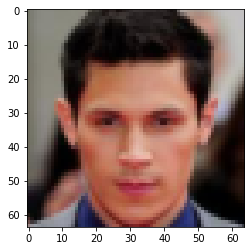

In [22]:
#data.train_dataset
print("data.train_dataset :", data.train_dataset)
sample_data = data.train_dataset[1200] #let's look at the first element

print("\nsample_data (0th data) (tuple)의 shapes (RGB 세개) : ", [i.shape for i in sample_data[0]])

#let's plot the first iamge
import cv2
import matplotlib.pyplot as plt

image_permute = sample_data[0].permute((1,2,0)) #matplotlib은 [H,W,C]로 받아서 axis permute해주기
plt.imshow(image_permute)

### 1.2.(?) Dataloader가지고 놀기

> `data.train_dataloader()`로 dataloader 바로 소환가능! (모듈이 그렇게 하다록 짜져있다)


결론(밑의 shape보기) : 
* input (image) batch : batch size 64, 64*64 RGB
* target batch : vector with 40 features

<br>

the shapes and stuff above is expected, since that is what we gave as input when loading the dataset, (`config["data_params"]`)

<br>

따라서, T1 image 넣고싶으면 이 `config`의 모든 것들 바꾸면 될듯!(not just its `data_params` key but all others)

In [23]:
train_loader = data.train_dataloader()

sample_batch = next(iter(train_loader)) #iterator object이니, 이렇게 one batch 빼내기 가능

print("sample_batch 의 type : ", type(sample_batch))
print("sample_batch의 type/contents : ", [i.shape for i in sample_batch])


/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


sample_batch 의 type :  <class 'list'>
sample_batch의 type/contents :  [torch.Size([64, 3, 64, 64]), torch.Size([64, 40])]


## 3. Actually Running the Vanilla VAE code (with some modification so that all can be run in this one notebook)

### X.0. Setting the configuration, and importing stuff

In [24]:
import torch
from models import BaseVAE
from torch import nn
from torch.nn import functional as F
from models import *

##importing the configureation 
#특히, 밑에서 보듯이, vanilla vae, `vae.yaml`을 가져오자
with open("configs/vae.yaml", 'r') as file:
    try :
        config = yaml.safe_load(file) #loading the config of vae.yaml
    except : 
        print("load_failed")
config #let look at the config (dict type) we imported

{'model_params': {'name': 'VanillaVAE', 'in_channels': 3, 'latent_dim': 128},
 'data_params': {'data_path': 'Data/',
  'train_batch_size': 64,
  'val_batch_size': 64,
  'patch_size': 64,
  'num_workers': 4},
 'exp_params': {'LR': 0.005,
  'weight_decay': 0.0,
  'scheduler_gamma': 0.95,
  'kld_weight': 0.00025,
  'manual_seed': 1265},
 'trainer_params': {'gpus': [1], 'max_epochs': 100},
 'logging_params': {'save_dir': 'logs/', 'name': 'VanillaVAE'}}

### X.1. Importing the Dataset => 위에서 다 실험해본다음에 여기로 옮기기! (일단은 SKIP)

* `nn.Conv2d` 에서 inchannels 지정안해줘도 예가 알아서 할 수 있음

* Encoder, Decoder이 channels가 있다! (CNN + VAE쪽 공부해야할듯.. 나는 1D VAE만 공부함)


* 아!!! `nn.Linear`, `nn.Sequential`로 된것들은 model로 instantiate해서 print하면, 함수의 그것으로 나오구나!

study :

1. Ali Ghodsi Lecture: (1D array가정하기는 했지만, VAE개념 초반에 잡기 좋음) : https://www.youtube.com/watch?v=uaaqyVS9-rM&t=3151s

2. Stanford Lecture : (이 코드와 직접 연관있는 CNN + VAE) (특히, Convtranspose파트) https://www.youtube.com/watch?v=5WoItGTWV54&t=2442s

### X.2. Building the Model

#### Observations

1. 밑에서 보듯이, `print(model)`을 하면, `self.{name} = nn.` 식으로 `nn`의 module로 된것이 print된다! (`self.haha = 3`같은 것은 print안됨!)
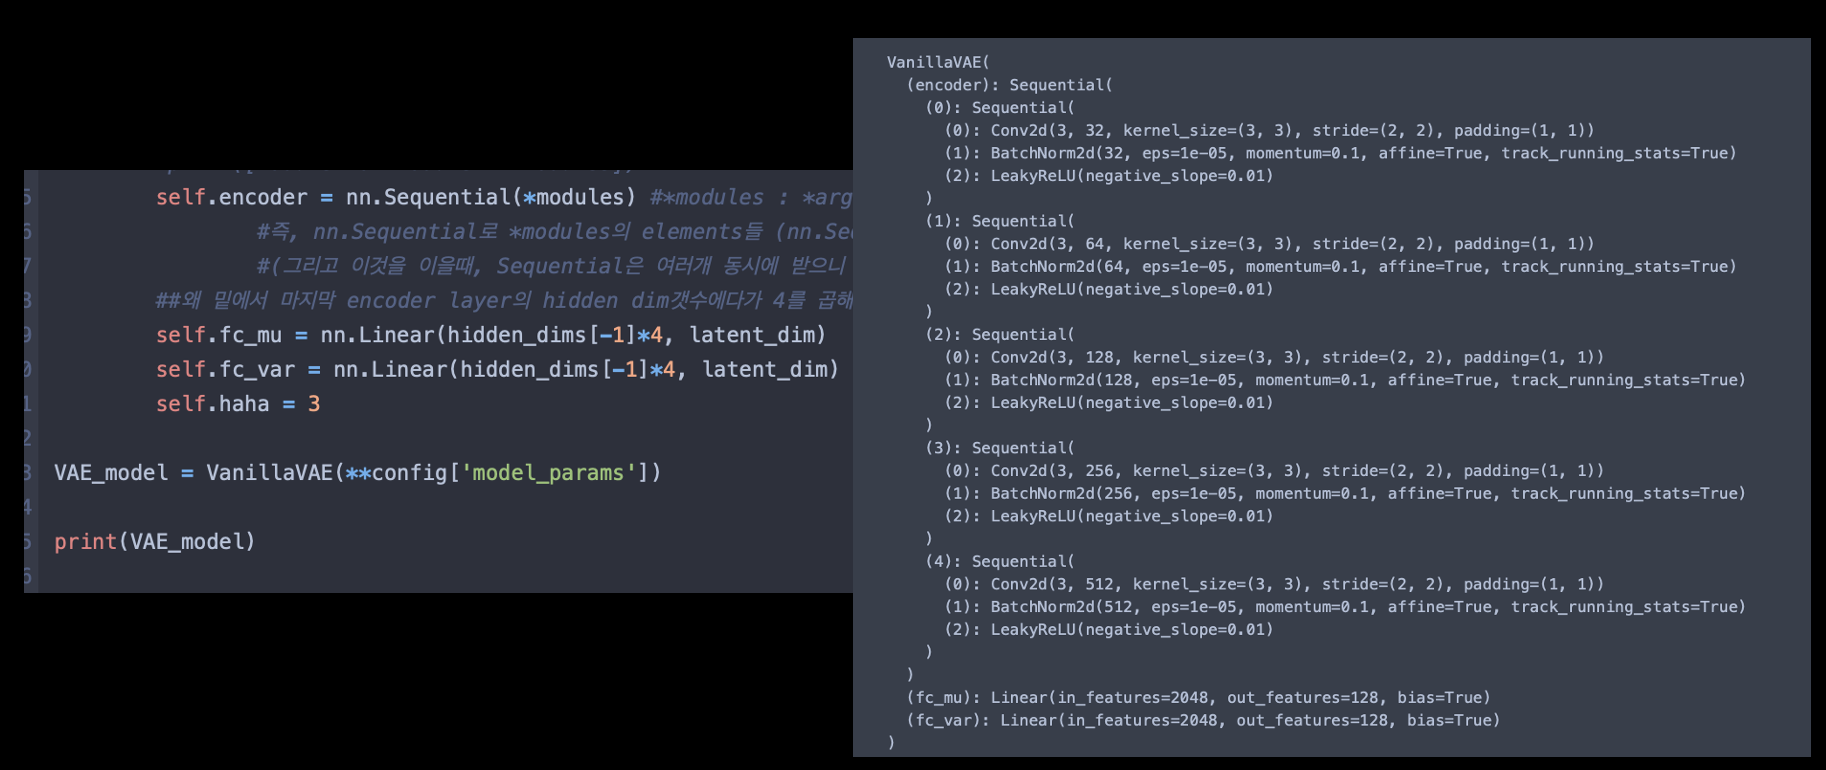


2. 밑에서 보았듯이, nesdted `nn.Sequential` 도 가능!

#### X.3. Questions

1. Question 1 : why use `[-1]*4`?
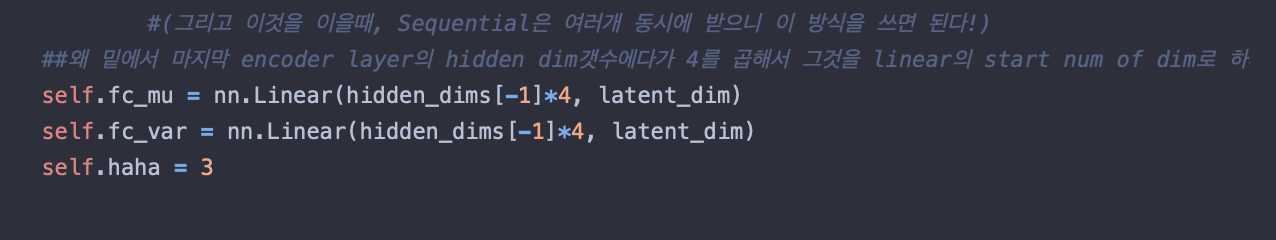

Answer : CNN 거친후 이미지형태가 2x2여서

2. `input`은 이미 built-in function인데 밑에처럼 변수로 써도 흠... 불편함이 없어야 하는건가? 작동은 하는데 나만 불편한건가요?? convention이 어떻게 되나요?
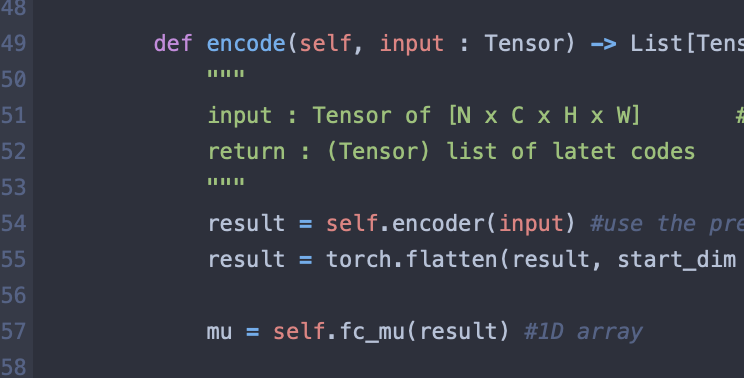

Answer : 좋은 convention은 아님

3. 밑의 질문 :
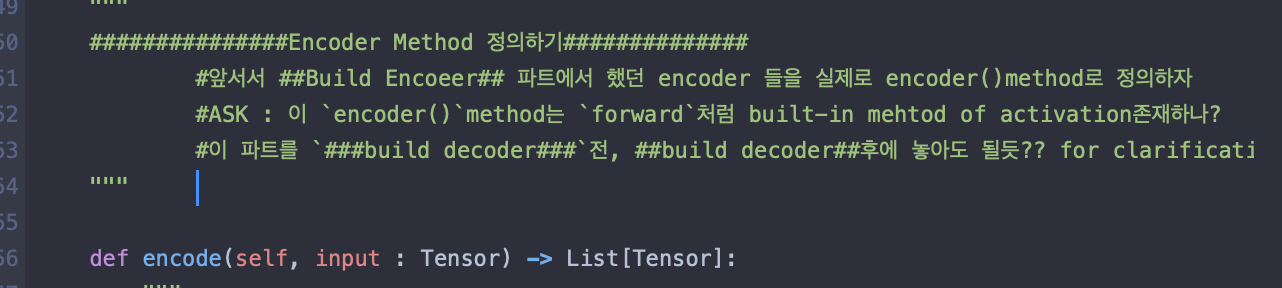


#### X.4. Do the following
* Track the size changes below and compare to the CNN code that I learned to see if it works

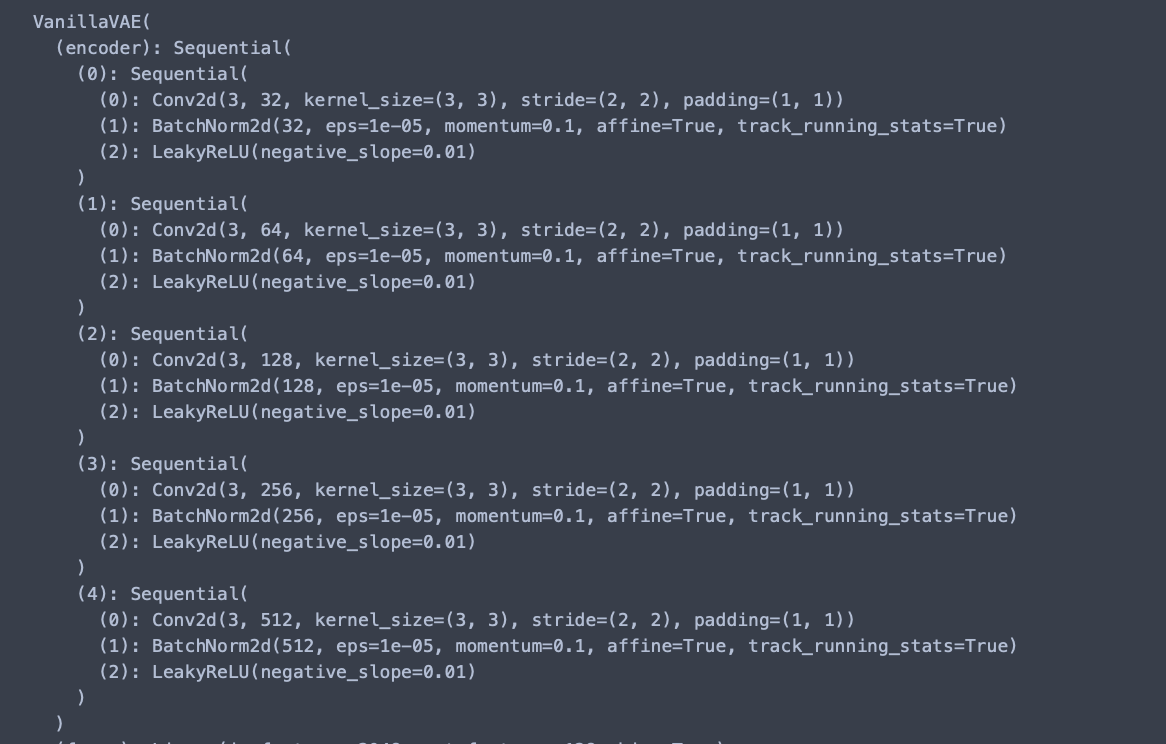

### X>X>X>X additional supplmenetary infor : 나중에 위로 옮기기

In [25]:
hidden_dims = [32,64,128,256,512]

print([i for i in hidden_dims])
print([i for i in hidden_dims[::-1]])

hidden_dims.reverse()
print(hidden_dims)
print([hidden_dims[i] for i in range(len(hidden_dims)-1)]) #즉 마지막 꺼가 없어지는 듯...?


[32, 64, 128, 256, 512]
[512, 256, 128, 64, 32]
[512, 256, 128, 64, 32]
[512, 256, 128, 64]


mean, std :  tensor(-0.0122) tensor(1.0000)


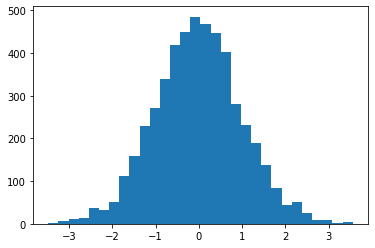

In [26]:
#prerequisite쪽으로 나중에 넣기 (normal distribution에서 값 하나 뽑는 것ㅎ)
a = torch.zeros(5000)

#default :  std of 1
b = torch.randn_like(a)
plt.hist(b, bins=30)
print("mean, std : ",b.mean(), b.std())

#즉, shape만 받는 것!


## 전체 code structure

1. `__init__` : 다양한 것들을 정의해놓음
2. `encode` : RGB image받아서 `[mu, logvar]`인 것들로 만듬 (later for reparametrization)(참고로 mu, logvar 둘다 batch dimension을 가지고 있음)
3. `reparametericzation` :encode에서 받은 `mu, logvar`가지고 normal PDF 만들어서 실제로 decoder input들을 만들기 
4. `decoder` : `reparameterization`에서 받은 input가지고 linear한번 거친 후 deflatten시켜서 (즉, image format으로 만들어서) 이미지를 reconstruct하기

ASK : 
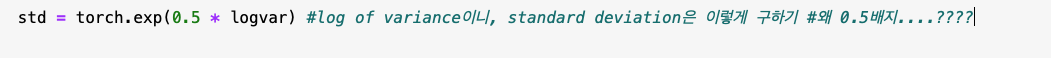

솔직히 근데 알아서 0.5배를 할것이기 때문에 상관은 없을 듯?


ASK :
        loss_function을 model내에서 정의해줌.. 왜이러지?? 이유가 있나?
        ==> 아마도 loss function의 정의 자체가 "part of the model definition" 이어서...?
        #잘 이해가 안된다... ASK
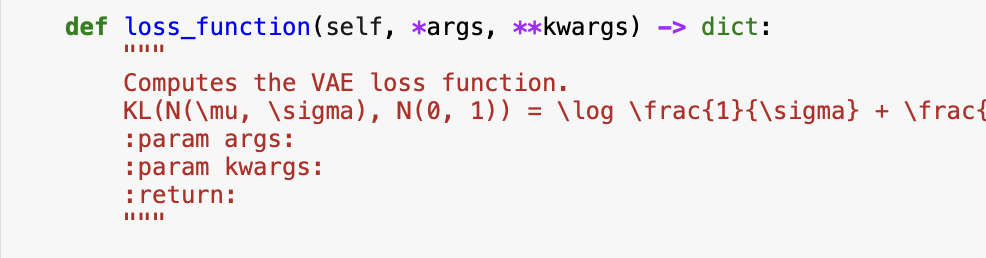


#### 밑의 모델이 왜 저렇게 되어있는지 => Supplementary 보기

In [27]:
#from .types_ import *                                         #이것대신 밑에서 직접 .py안에 있던 것을 가져왔다
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor') #Te

class VanillaVAE(BaseVAE): #BaseVAE doesn't have anythign meaningful I THINK
    def __init__(self,
                in_channels : int,
                latent_dim : int,
                hidden_dims : List = None,
                **kwargs) -> None:
        super(VanillaVAE, self).__init__()
        
        self.latent_dim = latent_dim #must be provided when initializing the VAE

        if hidden_dims is None:  #i.e. if not provided, use default
            hidden_dims = [32,64,128,256,512] #encoder/deconder stru
            
        """
        ###############Define Encoder nn modules (later used to define `def encoder()`)##############
        """

        modules = [] #will append to here the nn.Sequentials below 
        for h_dim in hidden_dims: #i.e. 32, 64, ...로 hidden dim (= channel 갯수)을 점점 키우면서 (ecoder)
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels = h_dim, 
                             kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())                  
            )
            in_channels = h_dim #i.e. the in_channel for the decoder is the last h_dim of the encoder (keeps updating)
        
        #print('======LETS LOOK AT MODULES========\n',[module for module in modules])
        self.encoder = nn.Sequential(*modules) #*modules : *args 수법이다 #즉, nn.Sequential로 *modules의 elements들 (nn.Sequential themselves) 를 이어서 encoder을 만든다!(그리고 이것을 이을때, Sequential은 여러개 동시에 받으니 이 방식을 쓰면 된다!)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim) #*4 because the image is 2*2
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)        

        
        """
        ###############Define Decoder nn modules (later used to define `def decoder()`##############
        """
        modules = []
        
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4) #i.e. latent dimension에서 다시 transpose convolution으로 들어가는 1D input
                                    #(reverse of the self.fc_mu, and self.fc_var)
        
        hidden_dims.reverse() #now hidden_dims will be [512, ..., 32]
        
        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(in_channels = hidden_dims[i],
                                       out_channels= hidden_dims[i+1],
                                       kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]), 
                    nn.LeakyReLU()
                )            
            )
        self.decoder = nn.Sequential(*modules)
        
        #이 final layer은 뭐하는 애인지 잘 모르겠다만... ㅋㅋㅋ 일단 넘어가보자
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=hidden_dims[-1],
                              out_channels=hidden_dims[-1], ###?????이건 뭐지... model structure을 잘 봐야할듯...?? (똑같은 channel갯수 두번?)
                              kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = hidden_dims[-1], out_channels=3, #이 layer이 마지막으로 이미지를 만들어내는 layer인듯 (out_channel = 3 means RGB)
                    kernel_size=3, padding = 1),
            nn.Tanh() #output을 0~1 사이의 값으로 한정...? 나중에 부풀려주나?
        )                

            
        """
        ###############Build Encoder/Decoder (앞서 쓴 encoder/decoder 들을 실제로 encoder(), decode () method로 정의하자#############
        """     

    def encode(self, input : Tensor) -> List[Tensor]:
        """
        input : Tensor of [N x C x H x W]       #N : batch size, C : channel size, H,W : image sizes
        return : (Tensor) list of latent codes (i.e. mu, log_var)
        """
        result = self.encoder(input) #encoder에 input을 넣어기
        result = torch.flatten(result, start_dim = 1) #encoder 결과를 flatten하기 거기다가 `nn.Linear` 해서(mu, var 구하기 위해서)
                                                        #.view[-1...]로 했어도 됬을 듯
        #flatten 된것 가지고, mu, var 구하기
        mu = self.fc_mu(result) #1D array를 
        log_var = self.fc_var(result) #var이 아니라 log_var인 이유? => 뭐라고 정의하든 상관없다 (Linear이 알아서 해주니)
        
        return [mu, log_var] #list를 return한다!
    
    
    def reparameterize(self, mu : Tensor, logvar : Tensor) -> Tensor :
        """
        #encode의 결과인 평균과 분산값들에서 normal PDF로 해서 decoder input으로 넣어주기!
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        ##use : N(mu,var) = N(0,1) * std + mu
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar) #log of variance이니, standard deviation은 이렇게 구하기 #왜 0.5배지....????
        N_01 = torch.rand_like(std) #random값을 가져오기 #이게 N01의 standardization이 std값이 것이 아니라 
                                    #std의 shape를 가진 N(0,1) random 값 torch tensor을 하는 것!! (주의하기)
        return N_01*std + mu
        
    def decode(self, z : Tensor) -> Tensor:
        """
        Maps the given latent codes onto the image space.
        :param z: (Tensor) [B x D] #B : batch, D : latent dimension #transpose CNN 하기 전에 nn.Linear을 먼저 거친다 #latent dim => decoder CNN input
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z) #latent dim vec (1D)를 받아서 => decoder CNN용 input인 512*2*2 짜리 1D vector로 만들기
        result = result.view(-1, 512, 2, 2) # 앞에서 만든 1D vector을 decoder에 넣을 수 있는 image형태로 만들기 (512, 2,2) 형태로 만들기 (-1 : just for )
        result = self.decoder(result)
        result = self.final_layer(result) #result : convtranspose2d한후 Generated Image 만들기 (shape of (B, 3,  X, X)(3 : RGB Channels))
        return result
    
    ##밑에 보기전에, 다른 cell에 "encode/decode/reparam"을 순서대로 했을때 어떻게 나오는지 적음.. 그것보기! (그것을 보면, 밑에 forward가 그냥 자동으로 완성됨)
    
    def forward(self, input : Tensor, **kwargs) -> List[Tensor]: ##이제 encode, reparam, decode정의 했던 것들로 forward를 정의하자 (이것이 실제로 torch에서 쓰는 것)
        """
        encode, reparam, decode를 한꺼번에 돌리기 => tensor 만 output으로 보내지 말고, input, mu, log_var도 output으로 (list형태로) 내놓기!
            #input을 output으로 내놓는 이유 : (아마도) VAE는 loss계산시 input vs output을 봐야해서, input도 passing해주는듯
            #mu, log_var을 output으로 내놓는 이유 : 모르겠다
            
            #질문 : 근데 이렇게 해도 되나? loss구하거나 backprop할때 문제 없나? => computational graph만 보존되면 되니, loss정의시 output[0]이런식으로 하면 될듯!
        """
        mu, log_var = self.encode(input) #encode한번 거치기
        z = self.reparameterize(mu, log_var) #encode결과에서 random sample한번 하기 (reparameterization)
        result = self.decode(z) #decode 파트 돌리기
        
        return [result, input, mu, log_var]
    
    """ASK 이거 뭔지 잘 모르겠다!! 왜 여기서 loss_fn정의하는지부터 시작해서, 왜 args에서 input을받는지 등등"""
    """https://arxiv.org/pdf/1312.6114.pdf 
    https://www.oreilly.com/library/view/hands-on-convolutional-neural/9781789130331/5fd7b094-acd2-4a30-a916-e8cdd306f37b.xhtml   
    이것보면 나옴! (답변 : loss = KL distance (so that the gaussian doesn't blow up) + MSE loss여서 그것이다 )"""
    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        ####define parameters####
        ##*args로 받은 list에서 첫번째, 두번째.. elements들을 적절한 이름을 해서 저장
        #args가 내생각에는 forward의 결과인듯하다 (그러면 말이됨)
        recons = args[0]   #reconstruction결과 (forward[0])(i.e. output)
        input = args[1]    #input (forward[1])
        mu = args[2]       #avg
        log_var = args[3]  #log_var
        
        ##**kargs에서 받은 arguments (dict)도 가져오기!
        kld_weight = kwargs['M_N']  #?? 이건 뭐지...? # Account for the minibatch samples from the dataset #이 뜻은 또 뭐지?
                                    #뭔가 두 loss간에 weighting인듯 (reconstruction loss를 얼마나 weight를 줄지)
        
        ####compute the loss####
        ##reconstruction loss
        recons_loss = F.mse_loss(recons, input) #i.e. reconstruction loss term : MSE loss b/w input and output 
        
        ##KL loss 
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim = 1),dim = 0) #밑에 설명을 적음
        
        loss = recons_loss + kld_weight*kld_loss #sum of the loss #여기서 detach하면 안됨! (gradient descent할 것이기 때문에)
        
        return {'loss' : loss, 'Reconstruction_loss' : recons_loss.detach(), 'KLD:': -kld_loss.detach()} #minus!!
    
    def sample(self, num_samples : int, current_device : int, **kwargs) -> Tensor : 
        """
        Samples from the latent space and return the corresponding image space map.
        즉, 임의의 latent vector 을 input으로 넣고 그에 상응하는 결과들을 output한다(나중에 image-space map을 만들때 쓰임)
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim) #num_samples개의 
        z = z.to(current_device) #send to device
        
        samples = self.decode(z) #즉, batch dimension대신 그냥 num_samples가 들어간 것
        return samples
    
    def generate(self, x:Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """
        
        recon_img = self.forward(x)[0] #forward 에서 첫번째를 받아야함! (remember?)
        
        return recon_img
    
        
VAE_model = VanillaVAE(**config['model_params'])
#VAE_model = VanillaVAE(in_channels = 3, latent_dim = 3) #위와 똑같은 command, but easier to understand (doesn't use **kwags)
print(VAE_model)        


VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

## 3.2. 몇개 가지고 놀기 (reconstructed image보기 등등)

sample batch :  [torch.Size([64, 3, 64, 64]), torch.Size([64, 40])]


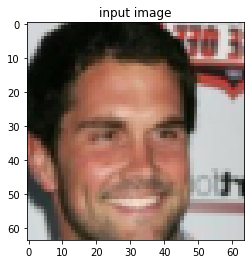

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


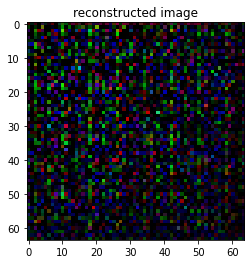

In [28]:
sample_batch = next(iter(train_loader)) 
print("sample batch : ", [i.shape for i in sample_batch])

image_permute = sample_batch[0][0].permute((1,2,0))
plt.imshow(image_permute)
plt.title("input image")

plt.show()

output = VAE_model(sample_batch[0])
output_detached = output[0].detach()[0]
plt.imshow(output_detached.permute((1,2,0)).numpy())
plt.title("reconstructed image")
plt.show()

# 4. Training
이제, model, dataloader, ... 도 만들었겠다, training loop정의해서 training시키자!

## Torch lightning을 쓰는데, 일단은 그냥 "아 어떻게 든지 되겠군" 만 하고 밑에 보자 (구체적 작동원리는 현재 상태에서는 과분할듯)
experiment.py 에서 `VAEXperiment`라는 모듈을 `pl.lightning`에서 상속받게 해서 lightning으로 train/val/test/sample_image등등을 하는데, 일단은 그냥 "black box"라고 생각하고 밑에를 보자 (구체적인 것을 하려면 일단 지금단계에서 하기는 너무 이르고, dataloader우리가 대충 만든 후에, 나중에 cVAE할때쯤 그때 (즉, train/test functino을 직접 손봐야하기 시작할떄) 그때 하는 것이 좋을 듯

초간단 이해 for lightning

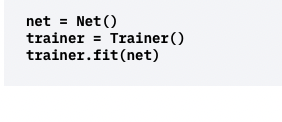

https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html
https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html
위에 보면 대충 나오기는 한다 (앞에 부분 10분정도마 보면 됨)

https://baeseongsu.github.io/posts/pytorch-lightning-introduction/
위의 사이트도 간단하게 잘 정리함

### ASK : 
1. Pin Memory?

In [ ]:
from experiment import VAEXperiment #pytorch lightning module을 상속하는 애가 있는데 그것을 가져온다
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.plugins import DDPPlugin
from pathlib import Path

###한꺼번에 다하기
#원래는 여기서 training만 해도 되지만, pl lightning써서 많이 간단해짐.. 그래서 여기서 dataloading부터 다 다시 해볼것임

print(config) #config we will use 

#dataloader/dataset정의
data = VAEDataset(**config['data_params'], pin_memory=len(config['trainer_params']['gpus']) !=0) #True in this case
data.setup() #setup()해주면 dataloader 등등이 생성이 됨 (source code보면 나옴)

#model생성
model = VanillaVAE(**config['model_params'])
        #직접 불러올때는 : model = vae_models[config['model_params']['name']](**config['model_params'])

#logger 생성 (tensorboard)
tb_logger = TensorBoardLogger(save_dir=config['logging_params']['save_dir'],
                             name = config['model_params']['name'])


#lightning wrapper 
    #model정의(이미 모델을 받아서 그대로 정의), training optimizer종류등등을 모두 정의
pl_model = VAEXperiment(VAE_model, config['exp_params']) 
            #pytorch lightning용 model (to be put into Trainer)에서는 train등등에 대한 정보가 필요해서 이것을 만듬
            #기존 VAE_model을 받아서 pytorch lightning에 쓰는 model 용으로 바꿔줌 (https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html)
        
#pl.Trainer 정의
runner = Trainer(logger = tb_logger,
                 callbacks=[
                     LearningRateMonitor(),
                     ModelCheckpoint(save_top_k=2, 
                                     dirpath =os.path.join(tb_logger.log_dir , "checkpoints"), 
                                     monitor= "val_loss",
                                     save_last= True),
                 ],
                 strategy=None, #DDPPlugin(find_unused_parameters=False), #이거는 여러 node쓰는 거라는데, interactive하게는 안된다고 해서 생략
                 **config['trainer_params'])

#make paths for saving/logging
Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)


print(f"======= Training {config['model_params']['name']} =======")
#실제로 runner.fit에 pl_model넣어서 training시키기
runner.fit(pl_model, datamodule=data) 


{'model_params': {'name': 'VanillaVAE', 'in_channels': 3, 'latent_dim': 128}, 'data_params': {'data_path': 'Data/', 'train_batch_size': 64, 'val_batch_size': 64, 'patch_size': 64, 'num_workers': 4}, 'exp_params': {'LR': 0.005, 'weight_decay': 0.0, 'scheduler_gamma': 0.95, 'kld_weight': 0.00025, 'manual_seed': 1265}, 'trainer_params': {'gpus': [1], 'max_epochs': 100}, 'logging_params': {'save_dir': 'logs/', 'name': 'VanillaVAE'}}


/home/connectome/dyhan316/.conda/envs/VAE_3DCNN/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=[1])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[1])` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


======= Training VanillaVAE =======


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3]

  | Name  | Type       | Params
-------------------------------------
0 | model | VanillaVAE | 3.9 M 
-------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.751    Total estimated model params size (MB)


Epoch 0:  18%|█████████████▊                                                                | 504/2856 [01:21<06:20,  6.18it/s, loss=0.03, v_num=6]

In [ ]:
print(config['data_params'])
print(config['model_params'])
print(config['exp_params'])
print(config['trainer_params'])
print(config['logging_params'])


len(config['trainer_params']['gpus']) !=0

# 5.  training결과 보기
use `tensorboard logger`

**tensorborad 사용법 : 밑에 간단하게 요약이 되어있다** (from 수영쌤)
https://swimming-whale.notion.site/Tensorboard-ce4da477e5344f818425003284e77b97

<br> 

이것을 우리가 이제 쓰는 방법 : 
1. `events.out.tfevents.1662362904.node3.343023.0` 파일 (tensorboard file)이 있는 directory로 가기 (`http://localhost:10033/tree/PyTorch-VAE/logs/VanillaVAE/version_1`) 
2. 거기서 `tensorboard --logdir . --host=0.0.0.0 --port={port 번호}`를 하기 
3. tunneling하기 (랩서버 접속할때 똑같이, 단 port번호 바꿔서)

결과 : 
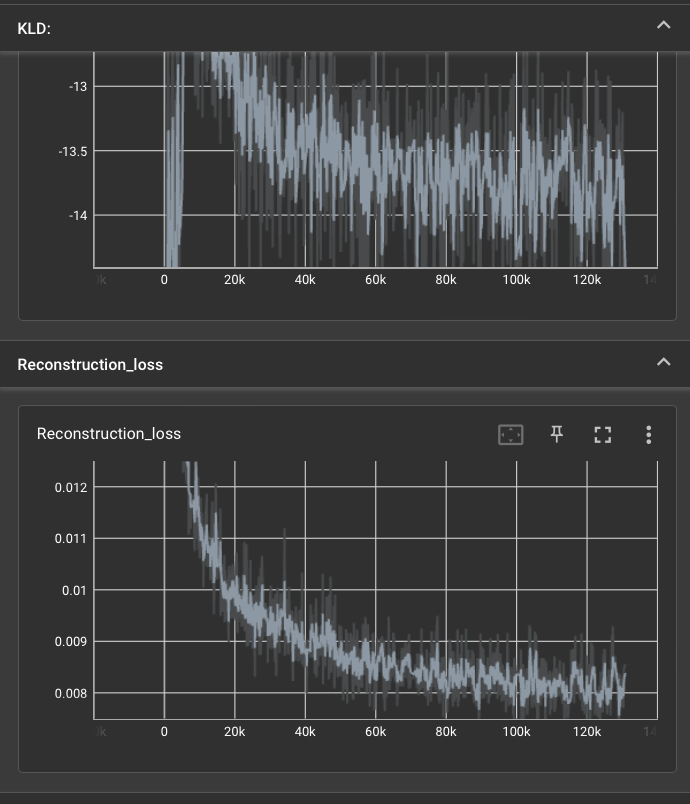


In [ ]:
#앞에서 "tb_lgoger" 만들어서 한것 거기다가 TensorBoardLogger로 다양한 것들이 저장아 됨!! 

# S. Supplmentary
앞의 내용들을 이해하기 위해서 여기다가 풀어놓은 것



## S.1. 생략

## S.2. 생략(일단은 없다)

## S.3. 3번의 파트에서 supplementary stuff
밑에서, decode, encode, 등등파트가 있는데 이들을 하나하나 model안에서가 아닌 밖에서 꺼내서 보도록 하겠다 (이해를 위해)

In [ ]:
#주의하기 : `self.decode`, `self.decoder`두개가 다름!! (너무 이름이 비슷해서 헷갈리기 쉬움)

### S.3.1. encode/decode/reparameterization 해보기

In [ ]:
###TRYING encode/decode/reparameterization### 4.3.1. encode/decode/reparameterization 해보기 code (before doing forward)

sample_batch = next(iter(train_loader)) 
print("sample batch : ", [i.shape for i in sample_batch])

#encode 돌려보기
print("\n==============")
encode_result = VAE_model.encode(sample_batch[0]) #[0] because list에서 앞의 것만 data이고 뒤는 label이니 (dataloader나중에 input으로 넣으면 
        #dataloader이 이걸 알아서 해주기는 함)
        #참고로, nn은 batch 단위로 주는 것을 단정하고 있기에, [0][0]이 아닌 [0]이다! 
        #(i.e. not a single image, but a single batch)
print("encoder result : ",[i.shape for i in encode_result]) 

#reparam돌려보기 (encoder결과 넣어서)
print("\n==============")
reparam_result = VAE_model.reparameterize(encode_result[0], encode_result[1]) #[0] : mu, [1] : logvar
print("reparam result : ",reparam_result.shape) #즉, mu,logvar tensor의 list를 받아서 128dim latent vector (batch 64)를 만든다


#decode 돌려보기 (reparam결과 넣어서)
print("\n==============")
decoder_result = VAE_model.decode(reparam_result)
print("deocder result : ",decoder_result.shape)

### S.3.2. Forward 해보기

In [ ]:
###forward돌려보기
#앞에서 encode, reparam, decode 했었는데, 그것을 이제 한꺼번에 묶은 (+ input, mu, log_var도 내놓는) forward를 해보자
forward_result = VAE_model(sample_batch[0])
print("forward의 결과들 : ",[i.shape for i in forward_result])
    #역시, output, input, mu, log_var shape들이 보인다

### S.3.3. Loss 구하기 (reconstruction loss + KL loss)


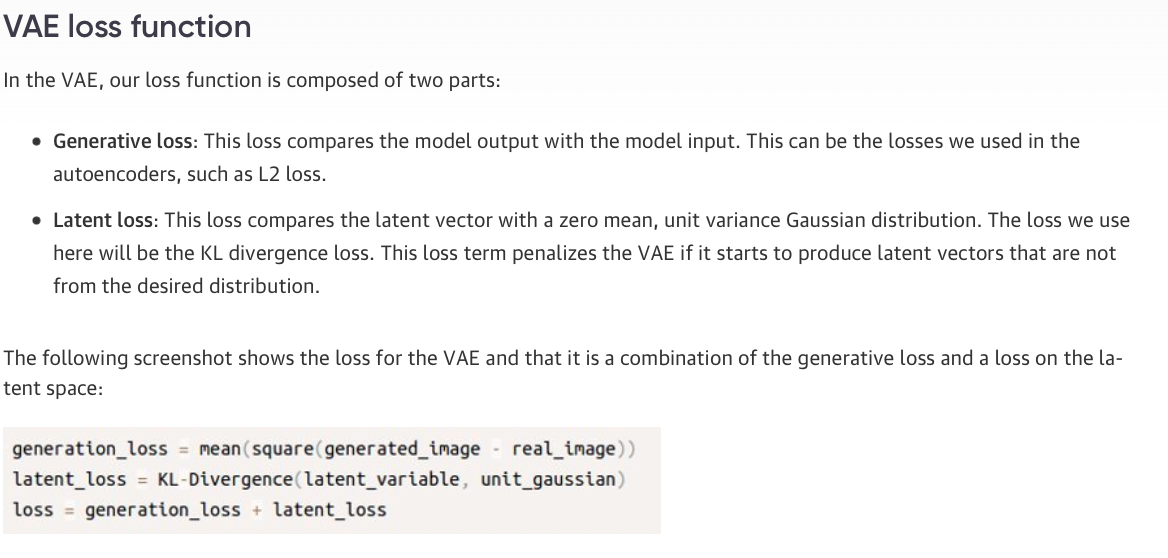

--definition of KL distance--
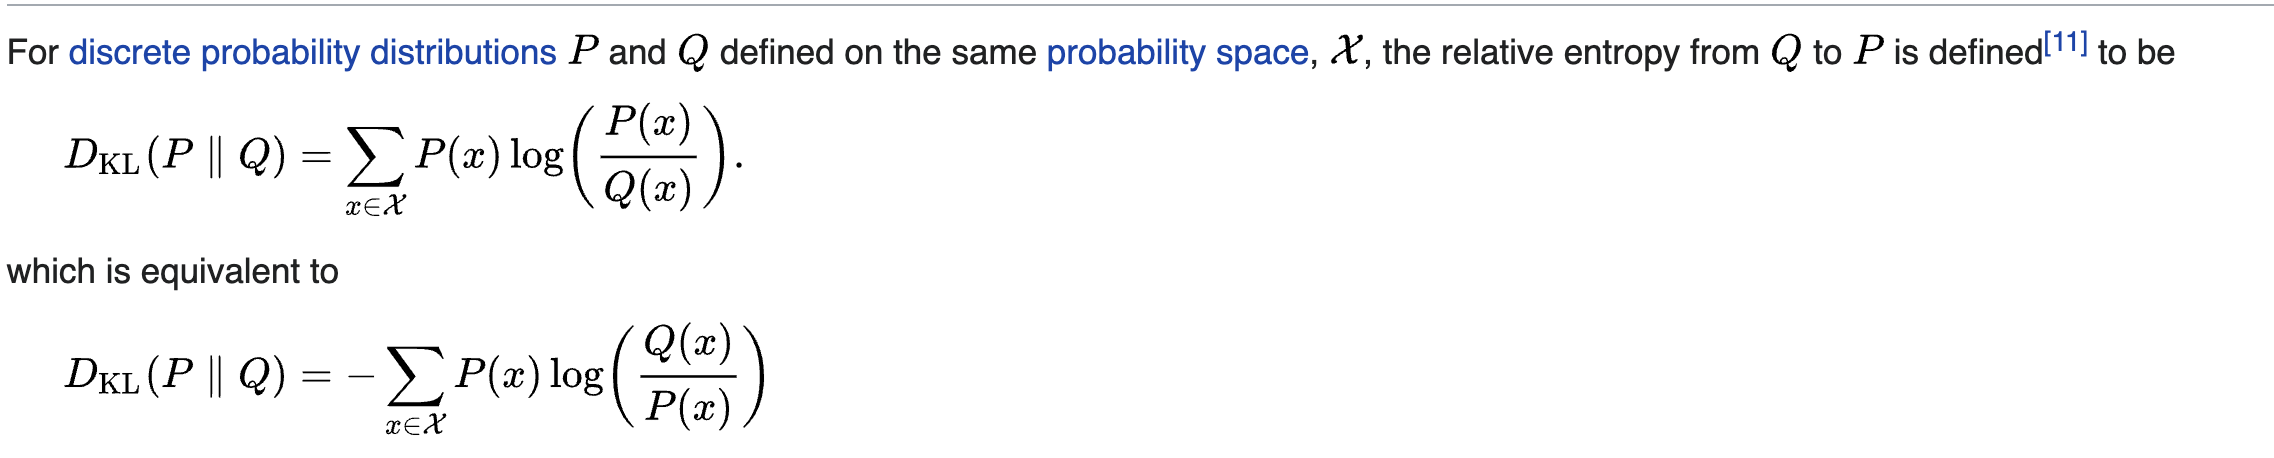

우리 같은 경우, 위에서 P(x)가 N(mu, e^log_var)가 되고 Q(x)가 N(0,1)가 된다 

### KL loss part 유도
일단 밑의 식 : KL of two normal distributions
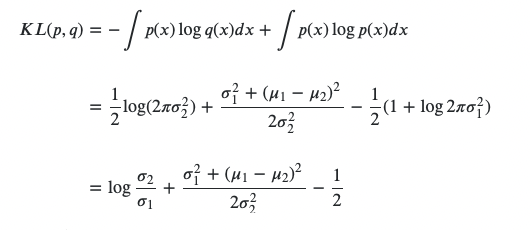

위의 식에서 이제 유도를 하자
$ = -1/2(-2\log(1/\sigma_1)-2\frac{\sigma_1^2 + \mu_1^2}{2}+1)$ ($\because \mu_2 = 0, \sigma_2 = 1$)


$ = -1/2(2\log(\sigma_1) - \sigma_1^2 - \mu_1^2 + 1)$

since $\sigma_1 = \sqrt{\text{var}}$

$ = -1/2(2\log(\sqrt{\text{var}}) - (\sqrt{\text{var}})^2 -\mu_1^2 + 1)$


$ = -\frac{1}{2}(\log{\text{var}}-\text{var} - \mu_1^2 + 1)$

**QED** (위의 식이 실제로 코딩으로 쓰이는 식)


**documentation의 식**

$KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}$

즉, 위의 두 식은 일치! (\sigma와 var이 다르다는 것 주의)

In [ ]:
#######loss돌려보기######
##setup
recon_output = forward_result[0]
input_tensor = forward_result[1]
mu = forward_result[2]
log_var = forward_result[3]
print("output, input의 shapes: ", recon_output.shape, input_tensor.shape)

##MSE loss F.mse_loss로도 보고, 실제로 뭔지도 보기
print(F.mse_loss(recon_output, input_tensor).detach() - torch.sum((recon_output-input_tensor)**2)/(64*3*64*64))
#즉, 둘이 똑같다! (이렇게 하면 mse_loss가 어떤 원리인지 바로 이해가능)

##KL diveregence보기
#위의 설몇에서 나오듯이, we want to compute KL(N(mu, sigma), N(0, 1)) (i.e. 두 distribution간의 거리)
print(mu.shape) #[64,128] 이니, 총 64개의 128dim normal distributino만들어야함 => 그 후 이 64를 average하기

#64개 동시로 P(x)/Q(x)하기 (위의 식을 써서) : 
KL_loss = -1/2 * (log_var - torch.exp(log_var)-mu**2 + 1)
KL_loss = KL_loss.sum()/KL_loss.shape[0] #전체 다 sum한후 갯수 (64)만큼 나누기

KL_loss #실제, 오른쪽 코드와 동일torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

밑 : TRASH

In [ ]:
a = nn.Conv2d(1, 3, (3,3))
input_tnsr = torch.randn(2,1,3,3)
print(a(input_tnsr).shape)
print(a(input_tnsr[1:]).shape)


In [ ]:
512*4

In [ ]:
config['model_params']

In [ ]:
config['model_params']

In [ ]:
###밑의 것을 답지삼아 보기!### (its strucutre is the answer and so on)

print(vae_models)
print("==")
print(vae_models['VanillaVAE']) #즉, vanillaVAE작동 시키기 


#이미 작동한느 것 (from the module)을 보자
print(vae_models['VanillaVAE'](**config['model_params'])) #그 vanillaVAE에 model_params를 넣기
vae_models['VanillaVAE']

In [ ]:
(**config['model_params'])

In [ ]:
Wowfantastic1!

## 회사지원!!

## also look at the QnA Excel
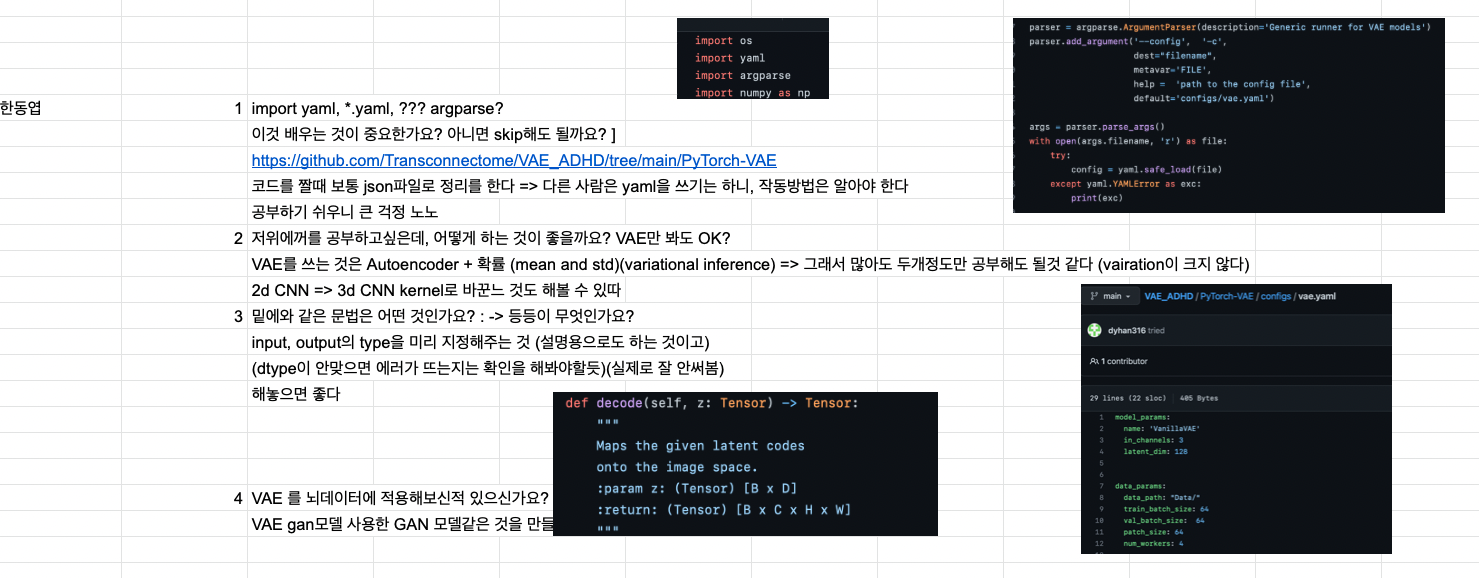

In [ ]:
List